<a href="https://colab.research.google.com/github/davJ-star/NLP/blob/main/kalman_filter_tfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

we use in navigation for robot, automous-driving... with slam
[kalman filter blog](https://blog.naver.com/ycpiglet/222139077774)


## Introduction

This is a simple illustration to show how one can use Kalman Filter support in Tensorflow Probability

## Imports



In [1]:
import functools
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

# alias
tfd = tfp.distributions

## Synthetic Data Generator

This is a simple synthetic dataset generator class that can be used to generate latent (state) variable with noise as well as the observed variables

Only 1-D has been tested so far! Expect sharp edges :(

In [2]:
class SyntheticDataSetGenerator(object):
  """ Linear transition and emission functions """
  def __init__(self,
               z_dim:int,
               z_drift:float,
               init_z_mu:float,
               init_z_cov:float,
               trans_cov:float,
               obs_dim:int,
               obs_drift:float,
               obs_cov:float,
               obs_coeff:float):

    self.z_dim = z_dim
    self.z_drift = z_drift
    self.init_z_mu = init_z_mu
    self.init_z_cov = init_z_cov
    self.trans_cov = trans_cov

    self.obs_dim = obs_dim
    self.obs_drift = obs_drift
    self.obs_cov = obs_cov
    self.obs_coeff = obs_coeff

  def transition(self, z):
    return z + self.z_drift

  def emission(self, z):
    return self.obs_coeff * z + self.obs_drift

  def sample_normal(self, mu, cov):
    return mu + np.random.randn(*mu.shape) * np.sqrt(cov)

  def __call__(self, num_samples:int, num_steps:int):

    all_z = []

    # create the first z
    z_prev_mu = np.ones((num_samples,1,self.z_dim))*self.init_z_mu
    z_prev = self.sample_normal(z_prev_mu, self.init_z_cov)

    all_z.append(z_prev)

    # now we generate z for subsequent time steps using
    # z_prev as the one before first timestep
    for t in range(num_steps-1):

      # apply the transition function
      z_mu = self.transition(z_prev)
      z_prev = self.sample_normal(z_mu, self.trans_cov)

      all_z.append(z_prev)

    z_true= np.concatenate(all_z, axis=1)

    # generating the obs from these latent variables

    # apply the emission function on all these z
    obs_emitted = self.emission(z_true)
    # x_emitted acts as our mu
    obs_true = self.sample_normal(obs_emitted, self.obs_cov)

    return z_true, obs_true

In [3]:
# The Dataset Generator takes parameters
# so that we can customize the synthetic data
#
# for now tested only with below configuration

syn_ds = SyntheticDataSetGenerator(
      z_dim = 1,
      z_drift = 0.05,
      init_z_mu = 0,
      init_z_cov = 1.,
      trans_cov = 10.,
      obs_dim = 1,
      obs_drift = 0.,
      obs_cov = 20.,
      obs_coeff= 0.5)

In [4]:
z_true, obs_true = syn_ds(5000, 25)
z_true.shape, obs_true.shape

((5000, 25, 1), (5000, 25, 1))

## Plotting Helpers

In [5]:
# a helper function to plot both latent variable
# and observation

def make_plots(
    sequences,
    x,
    z,
    extra_plots=[]):

  num_plots = len(sequences)

  fig, ax = plt.subplots(len(sequences), 2, figsize=(16, 8))
  fig.subplots_adjust(hspace=.5)

  def plot_x():
    for i in range(num_plots):
      d =  x[sequences[i]]
      x_axis = np.arange(len(d))
      ax[i][1].plot(x_axis, d, label='x')

  def plot_z():
    for i in range(num_plots):
      d =  z[sequences[i]]
      x_axis = np.arange(len(d))
      ax[i][0].plot(x_axis, d, label='z')

  plot_x()
  plot_z()

  # call the user supplied plot
  # functions (if any)
  for e in extra_plots:
    e(sequences, ax)

  left_side = ax[0,0]
  left_side.set_title('Latent Space')
  left_side.legend(loc='upper center', bbox_to_anchor=(0.5, 2.2),ncol=3, frameon=True)

  right_side = ax[0,1]
  right_side.set_title('Observations')
  right_side.legend(loc='upper center', bbox_to_anchor=(0.5, 2.2),ncol=3, frameon=True)

  plt.show(fig)

In [6]:
# specialized for training plots
make_train_plots = functools.partial(make_plots, x=obs_true, z=z_true)

The below plot is showing 3 randomly picked sequences

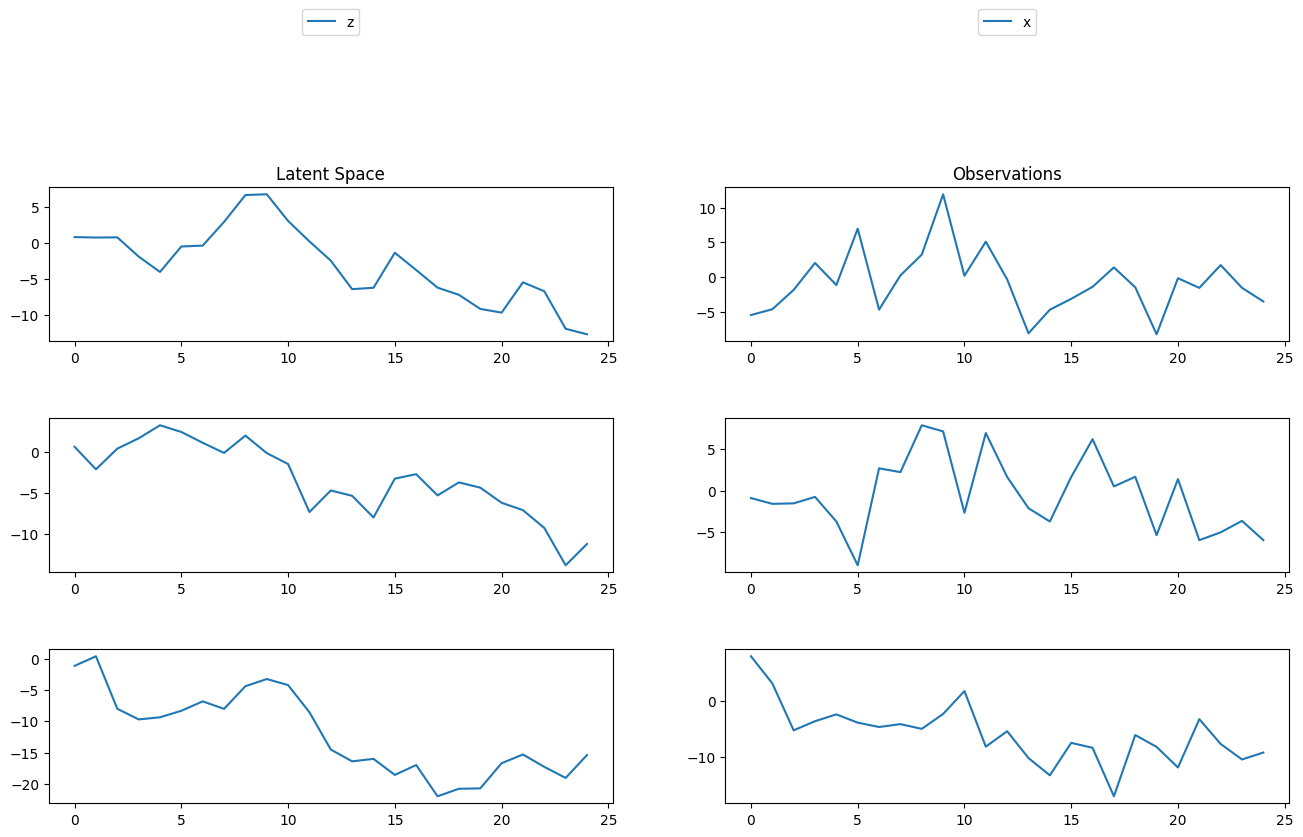

In [7]:
# just get a 3 random sequences to plot
np.random.seed(3)
sequences = np.random.permutation(10)[:3]

make_train_plots(sequences=sequences)

## Linear Gaussian State Space Model using TFP

In [8]:
def build_tfp_lg_ssm(syn_ds: SyntheticDataSetGenerator):

  transition_matrix = [[1.]]
  observation_matrix = [[syn_ds.obs_coeff]]

  transition_noise = tfd.MultivariateNormalDiag(
      loc = [syn_ds.z_drift],
      scale_diag= [syn_ds.trans_cov])

  observation_noise = tfd.MultivariateNormalDiag(
      loc = [syn_ds.obs_drift],
      scale_diag = [syn_ds.obs_cov])

  initial_state_prior = tfd.MultivariateNormalDiag(
      loc =[syn_ds.init_z_mu],
      scale_diag = [syn_ds.init_z_cov])

  model = tfd.LinearGaussianStateSpaceModel(
    num_timesteps=25,
    transition_matrix=transition_matrix,
    transition_noise=transition_noise,
    observation_matrix=observation_matrix,
    observation_noise=observation_noise,
    initial_state_prior=initial_state_prior)

  return model

model = build_tfp_lg_ssm(syn_ds)

In [9]:
# Make a tensorflow dataset
X_train = tf.data.Dataset.from_tensors(obs_true)

# batch it up
x = next(iter(X_train.batch(batch_size=5000).map(lambda x : tf.cast(x, dtype=tf.float32))))[0]
print(x.shape)

(5000, 25, 1)


In [10]:
_, filtered_means, filtered_covs, _, _, _, _ = model.forward_filter(x)

In [11]:
filtered_means.shape, filtered_covs.shape

(TensorShape([5000, 25, 1]), TensorShape([25, 1, 1]))

In [12]:
def plot_tfp_kalman_z(sequences, ax):
  for i in range(len(sequences)):
    d =  filtered_means[sequences[i]]
    x_axis = np.arange(len(d))
    ax[i][0].plot(x_axis, d, label='z_tfp_kf')

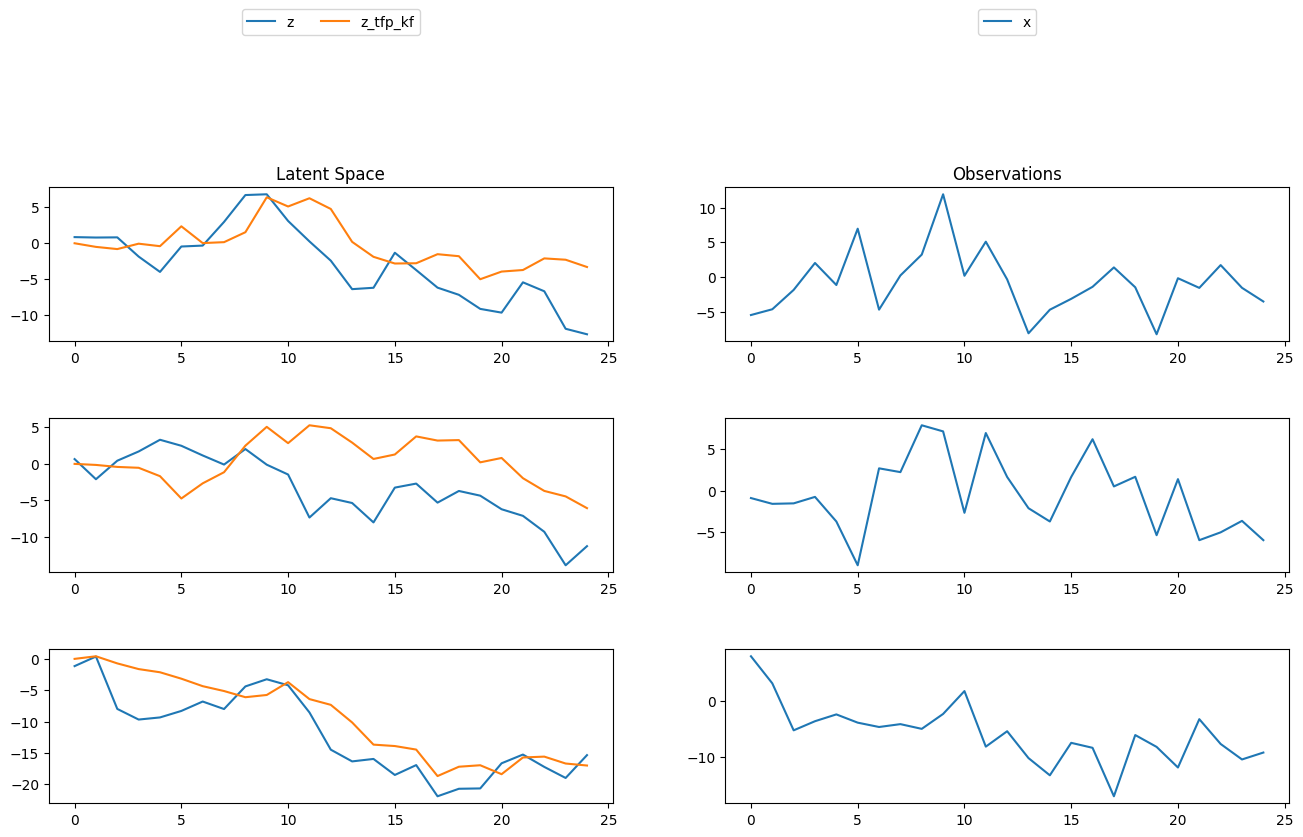

In [13]:
# change seed to other seqeuences
np.random.seed(3)
sequences = np.random.permutation(10)[:3]
make_train_plots(
    sequences=sequences,
    extra_plots=[plot_tfp_kalman_z])

In [14]:
current_location_posterior = tfd.MultivariateNormalTriL(
              loc=filtered_means[..., -1, :],
              scale_tril=tf.linalg.cholesky(filtered_covs[..., -1, :, :]))

In [15]:
current_location_posterior.sample()

<tf.Tensor: shape=(5000, 1), dtype=float32, numpy=
array([[ 20.529757 ],
       [ -8.152415 ],
       [ 10.72692  ],
       ...,
       [  0.5168288],
       [-28.464336 ],
       [ 85.603645 ]], dtype=float32)>